In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

import mlrfit as mf
import mfmodel as mfm
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import random
import umap
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Markdown, display
# from utils import plot_features, plot_Euclidean_dist, standardize_data, order_attribute, plot_fa, plot_fa2, plot_fa3

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
today = datetime.today()
date = "%d-%d"%(today.month, today.day)
mtype = experiment_type = "exp_donor_tissue_r12_8_1_huge"

ranks = np.array([12, 8, 1])

np.random.seed(1001)
random.seed(1001)

sc.settings.set_figure_params(dpi=50, facecolor="white")

# Load and preprocess data

In [2]:
samples = {
    "bcell": "/Users/parshakova.tanya/Datasets/cross-tissue-immune-cell.h5ad"
}
adatas = {}

for sample_id, filename in samples.items():
    sample_adata = sc.read_h5ad(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(f"num_cells={adata.shape[0]}, num_genes={adata.shape[1]}")


num_cells=329762, num_genes=36398


In [3]:
unique_donors = adata.obs["donor_id"].unique()
print("Unique donor IDs:", unique_donors)

donor_counts = adata.obs["donor_id"].value_counts()
print(donor_counts)

Unique donor IDs: ['A29', 'A31', 'A36', 'A35', 'A37', ..., '621B', '637C', '640C', 'D503', 'D496']
Length: 12
Categories (12, object): ['582C', '621B', '637C', '640C', ..., 'A37', 'A52', 'D496', 'D503']
donor_id
D496    88057
D503    79004
640C    35527
637C    25843
A36     24105
A29     17327
A31     12446
582C    11590
A35     11105
621B    10632
A37      9806
A52      4320
Name: count, dtype: int64


In [4]:
max_cells_per_donor = adata.obs.shape[0]
display(Markdown(f"## Filter {max_cells_per_donor} cells per donor"))

## Filter 329762 cells per donor

In [5]:
top_cells_indices = []

for donor in donor_counts.index:
    tissue_cells = adata.obs[adata.obs["donor_id"] == donor].index
    top_cells_indices += list(tissue_cells[:max_cells_per_donor])

filtered_adata = adata[top_cells_indices, :]
adata = filtered_adata

In [6]:
adata.obs["tissue"].value_counts(), adata.obs["sample"].value_counts()

(tissue
 spleen                    71962
 thoracic lymph node       62647
 bone marrow               40507
 lung                      35419
 blood                     27620
 jejunal epithelium        27087
 lamina propria            23687
 mesenteric lymph node     23197
 liver                     13368
 ileum                       890
 skeletal muscle tissue      835
 duodenum                    764
 omentum                     597
 caecum                      433
 thymus                      354
 transverse colon            262
 sigmoid colon               133
 Name: count, dtype: int64,
 sample
 bcell    329762
 Name: count, dtype: int64)

In [7]:
display(Markdown(f"## Preprocess data: filter mitochondrial genes, QC metric plots, filter cells with <100 genes"))
display(Markdown(f"## Normalize and logarithmie the data"))
n_top_genes = 500
display(Markdown(f"## Filter {n_top_genes} most variable genes"))

## Preprocess data: filter mitochondrial genes, QC metric plots, filter cells with <100 genes

## Normalize and logarithmie the data

## Filter 500 most variable genes

/var/folders/fp/rkwhsn_57zn3tz7fw_ct6s8m0000gn/T/ipykernel_26584/3423942450.py:3: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("MT-")
/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


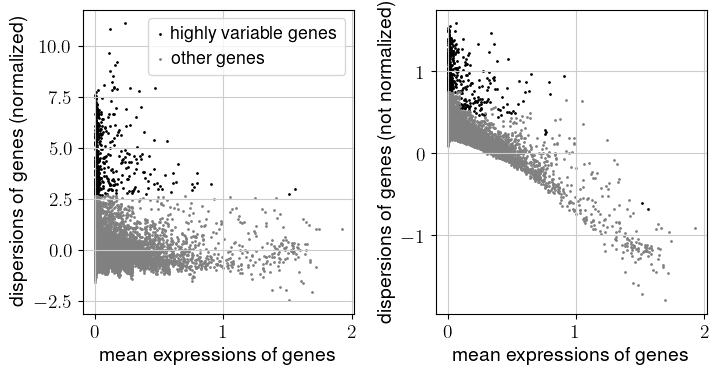

In [8]:
# Preprocessing data; quality control
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)


adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

# Based on the QC metric plots, one could now remove cells that have too many mitochondrial genes expressed or too many total counts by setting manual or automatic thresholds. However, sometimes what appears to be poor QC metrics can be driven by real biology so we suggest starting with a very permissive filtering strategy and revisiting it at a later point. We therefore now only filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells. 

# Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can very substantially between batches. 

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=200)

# Normalization

# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata)

# Logarithmize the data
sc.pp.log1p(adata)

# Feature selection

sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, batch_key="sample")

sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']].copy()

# Compute PCA
sc.tl.pca(adata, n_comps=50)

# Compute UMAP
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=5)  # using PCs computed previously
sc.tl.umap(adata)

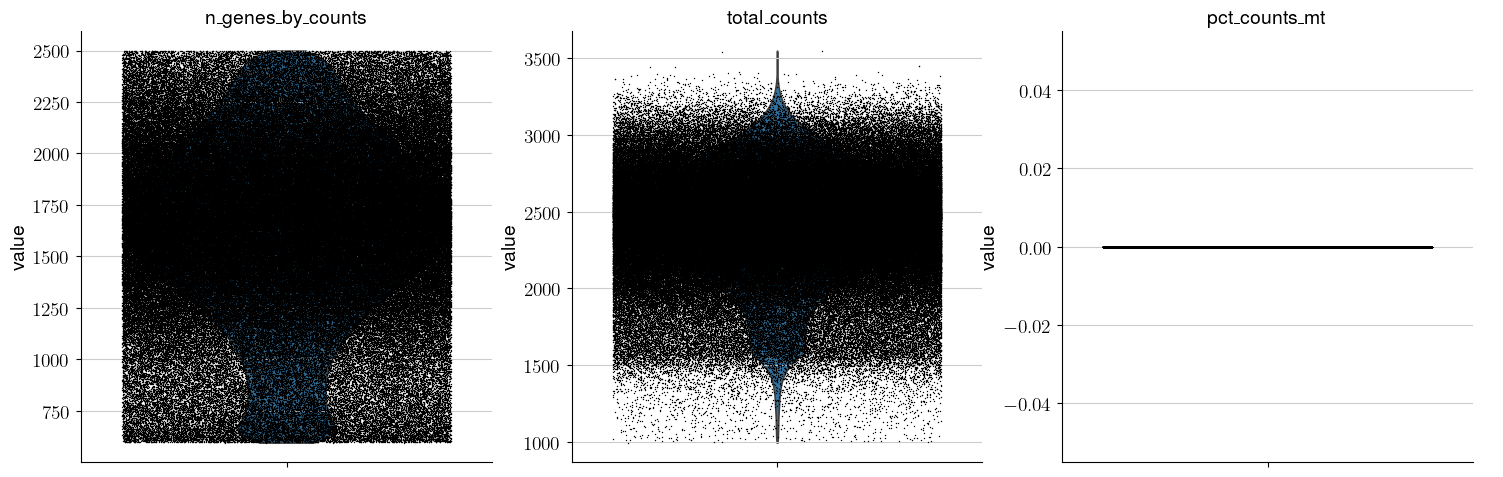

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [10]:
display(Markdown(f"# New num_cells={adata.shape[0]}, num_genes={adata.shape[1]}."))

# New num_cells=280535, num_genes=500.

In [11]:
tissue_c2g_hpart, tissue_F_hpart =  mfm.hpart_cellxgene_group(adata, "tissue")
donor_c2g_hpart, donor_F_hpart =  mfm.hpart_cellxgene_group(adata, "donor_id")

num_levels=3, num_sparsities=17
(17, 2) [ 0 16]
num_levels=3, num_sparsities=12
(12, 2) [ 0 11]


In [12]:
mfm.check_contiguous_group_cellxgene(adata, "tissue", tissue_c2g_hpart)
mfm.check_contiguous_group_cellxgene(adata, "donor_id", donor_c2g_hpart)

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/multilevel_factor_model/mfmodel/utils.py:243: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ordered = list(adata.obs[feat_type][pi_ord].values)


In [13]:
num_cells, num_genes = adata.X.shape

<Axes: title={'center': 'tissue'}, xlabel='PC1', ylabel='PC2'>

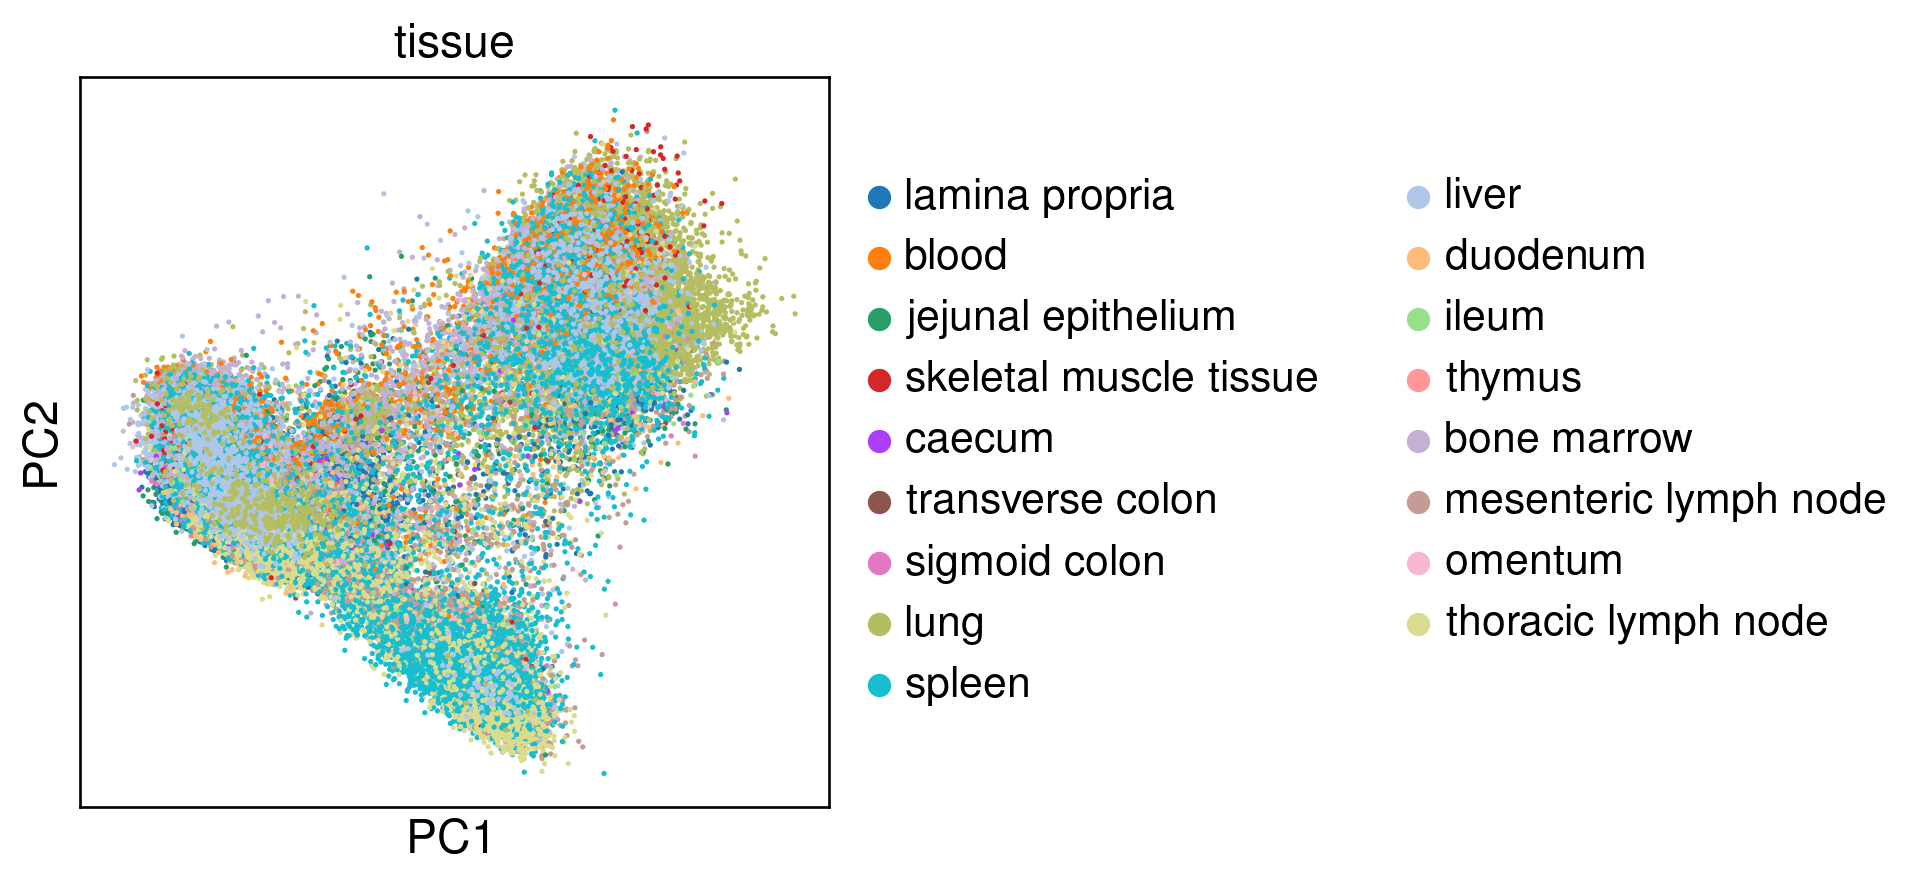

In [14]:
sc.set_figure_params(dpi=120)
sc.pl.pca(adata, color=["tissue"], show=False, size=10, cmap='tab20')

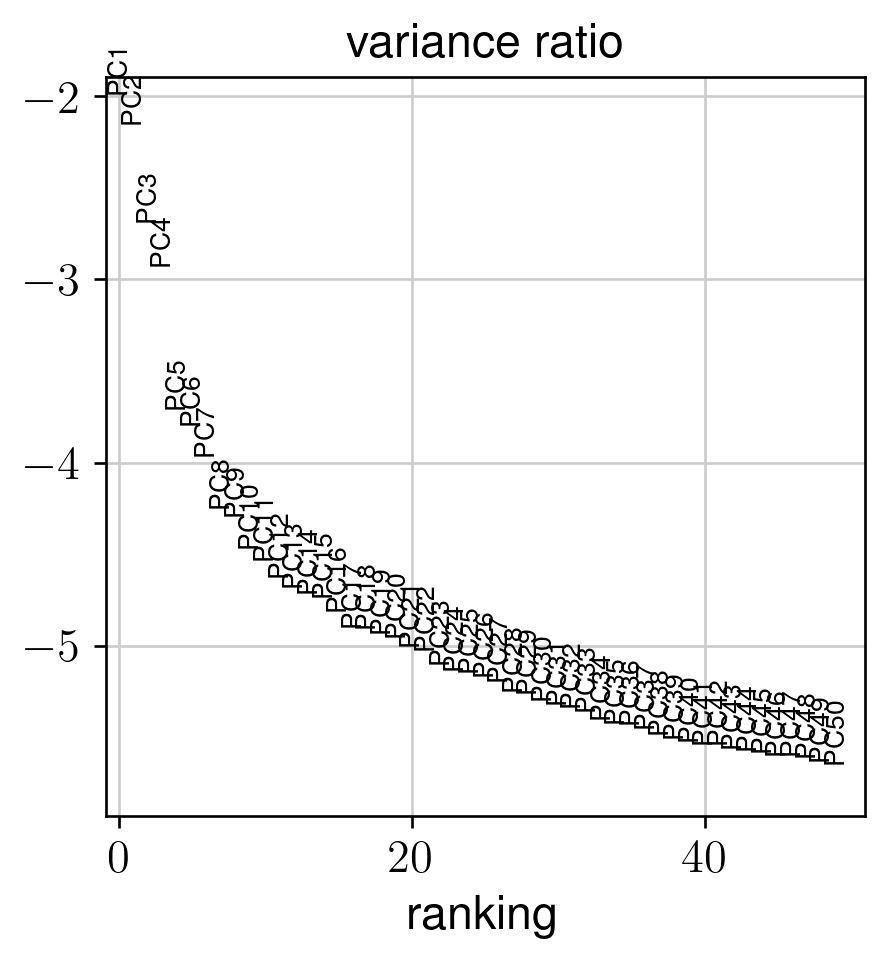

In [15]:
# Dimensionality reduction
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

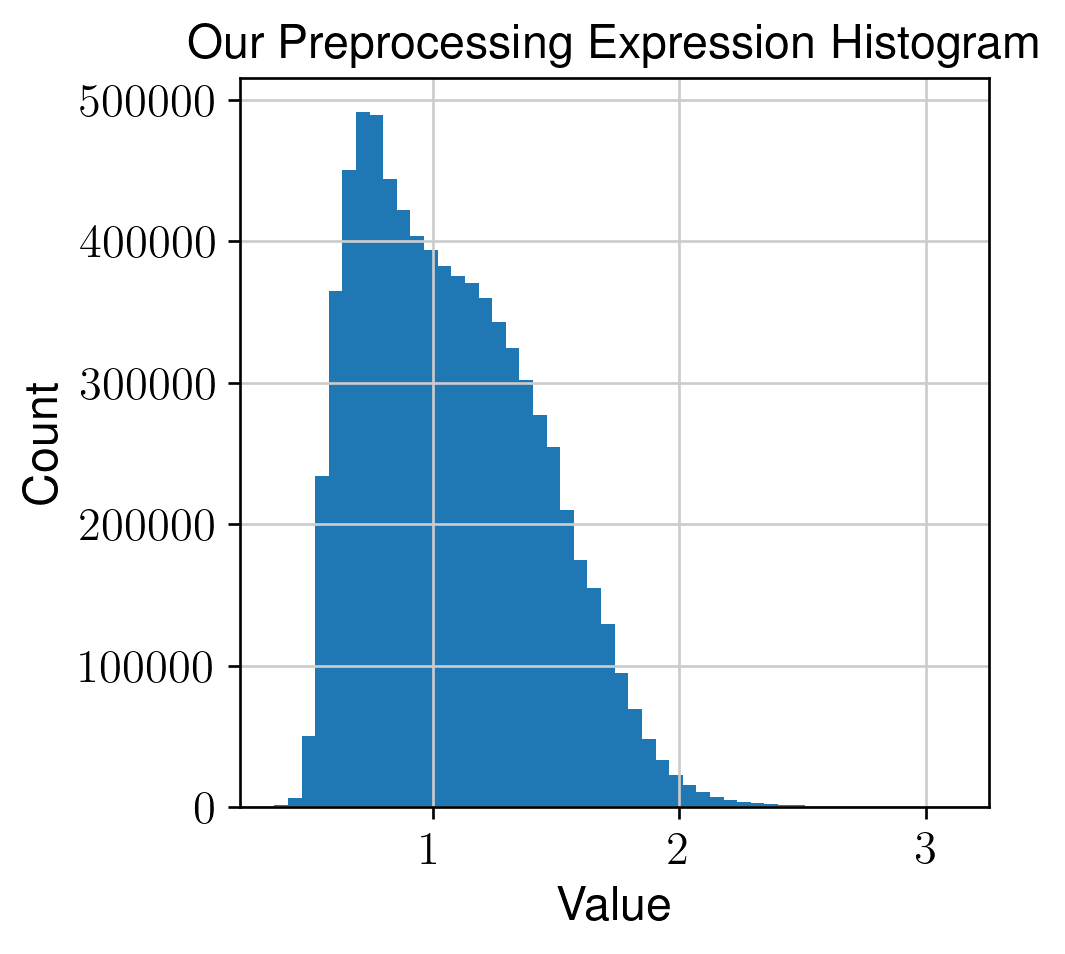

In [16]:
plt.hist(adata.X.data, bins=50)
# plt.yscale("log")
plt.title("Our Preprocessing Expression Histogram")
plt.ylabel("Count")
plt.xlabel("Value")
plt.show()

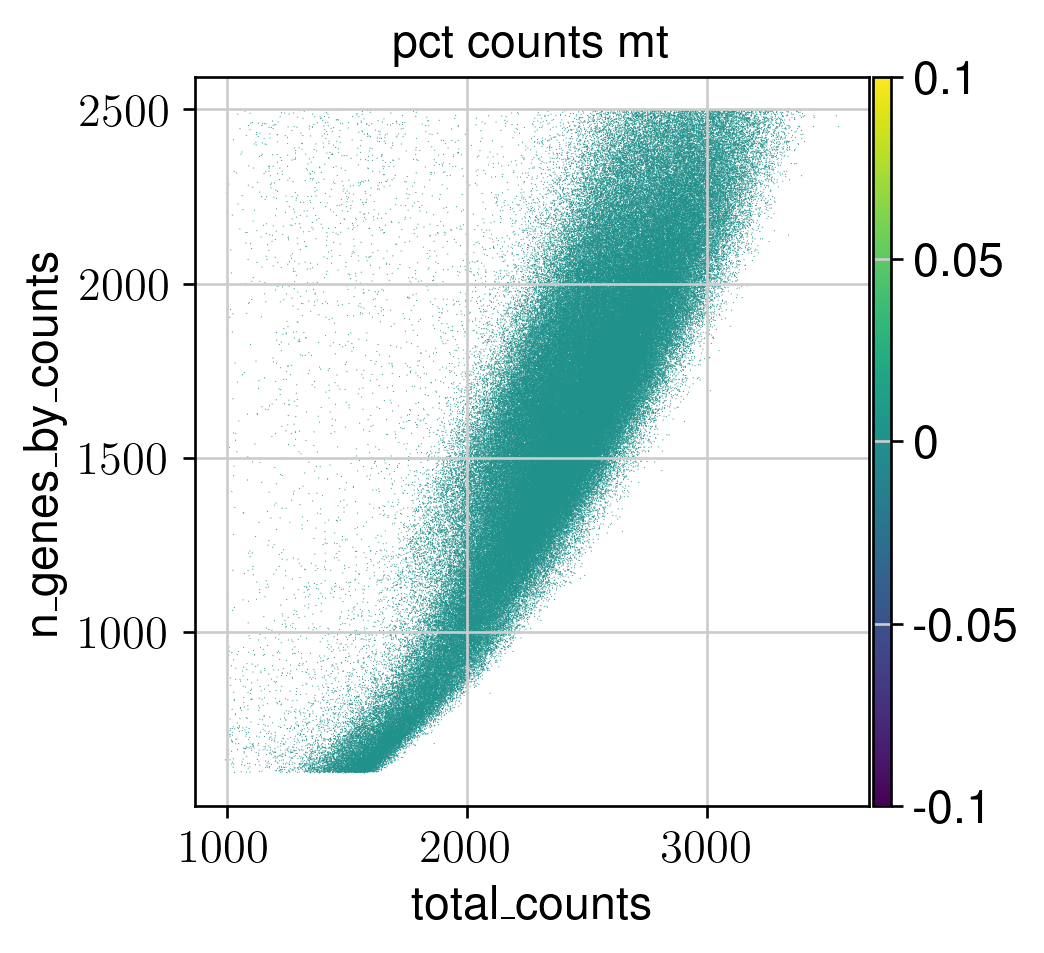

In [17]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

<Axes: title={'center': 'tissue'}, xlabel='UMAP1', ylabel='UMAP2'>

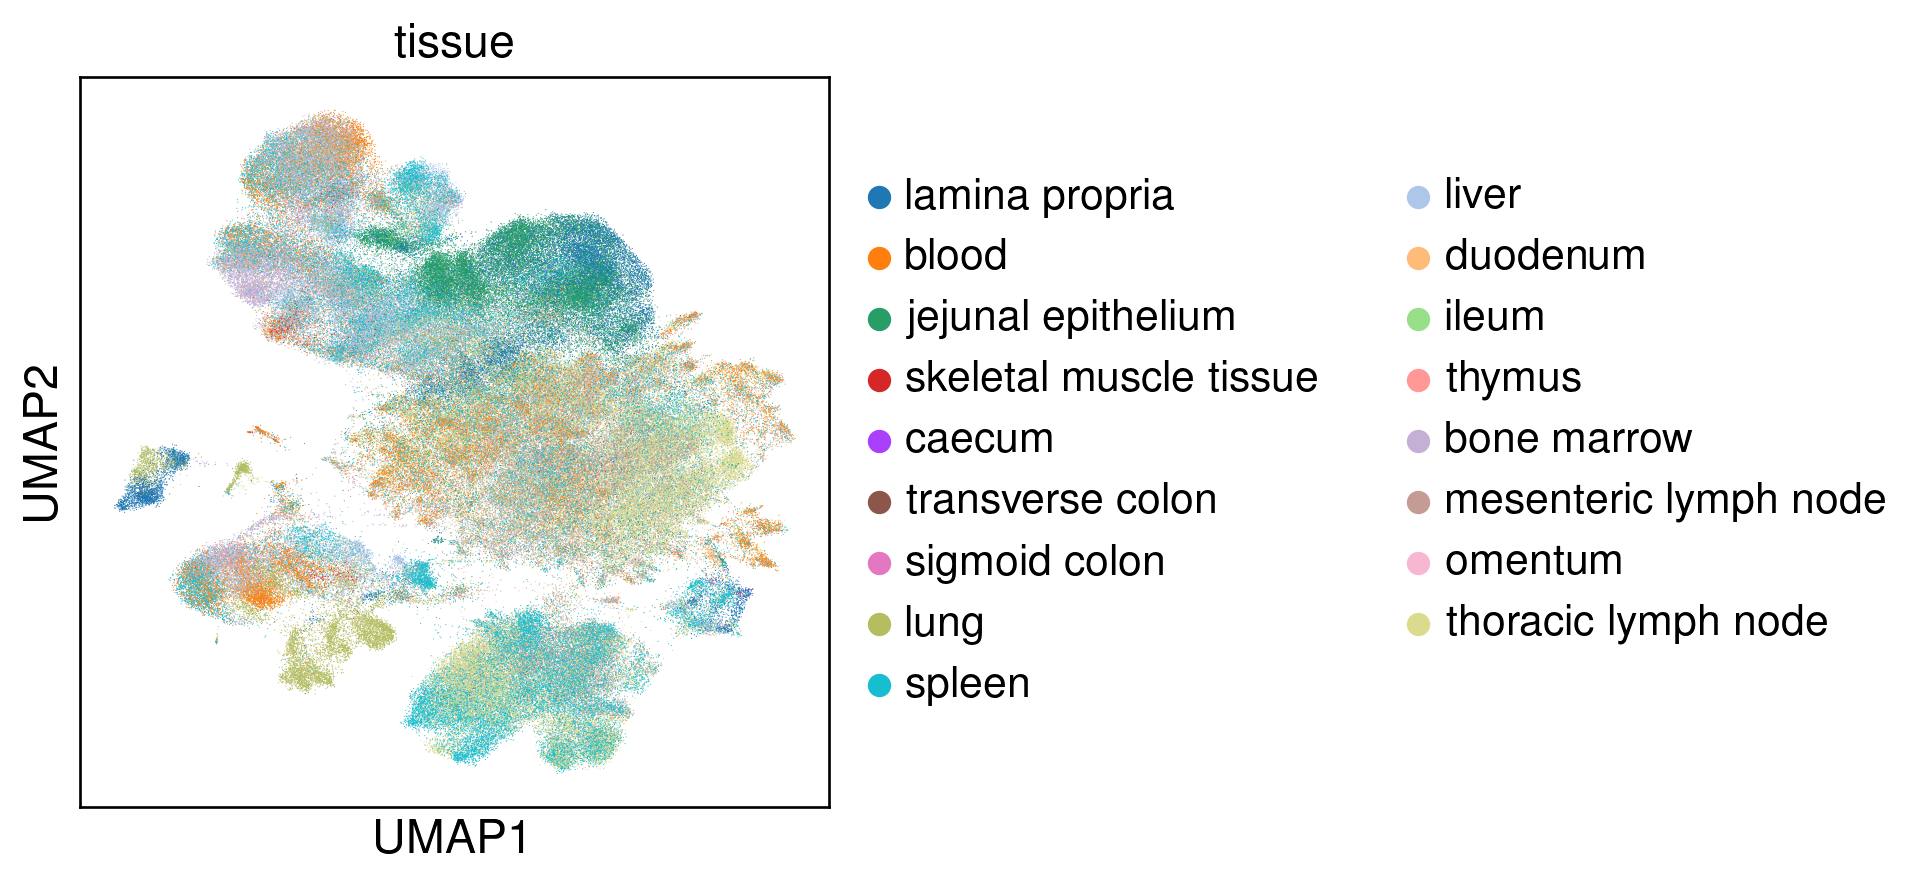

In [18]:
sc.pl.umap(adata, color=["tissue"], show=False, color_map='tab20')

# Standardize features

In [19]:
# Z = mf.demean_clip(adata.X.toarray().astype(np.float64), factor_std=3).astype(np.float32)
Z = mfm.standardize_matrix(adata.X.toarray().astype(np.float64).T, debug=True)
# permute columns of Y according to pi
Y = Z[:, donor_c2g_hpart["rows"]["pi"]]

In [20]:
Y.shape, Y.min(), Y.max(), np.mean(Y), np.median(Y)

((500, 280535),
 -0.5551973379868785,
 18.251364983618075,
 -1.7565059163727504e-20,
 -0.21288795510248754)

# MFM

In [21]:
diag_Sigma = np.einsum('ij,ji->i', Y.T, Y) / Y.shape[0]

In [22]:
fitted_mfm, loglikelihoods = mfm.fit(Y, ranks, donor_F_hpart, printing=True, max_iter=200, freq=10, init_type="frob")

t=0, obj=-222577.17384604653, hist(D)=(array([208451,  70841,   1243]), array([0.02858482, 0.35197424, 0.67536366, 0.99875309]))
t=10, obj=-218985.91260958082, hist(D)=(array([202991,  75116,   2428]), array([0.01056587, 0.34000916, 0.66945244, 0.99889573]))
t=20, obj=-218476.1011011798, hist(D)=(array([202861,  75020,   2654]), array([0.00910829, 0.3390469 , 0.6689855 , 0.99892411]))
t=30, obj=-218199.93244977866, hist(D)=(array([202393,  75282,   2860]), array([0.00723247, 0.33780089, 0.66836931, 0.99893773]))
t=40, obj=-217970.26450799615, hist(D)=(array([202901,  74647,   2987]), array([0.0072437 , 0.33780804, 0.66837237, 0.99893671]))
t=50, obj=-217866.25864785438, hist(D)=(array([203107,  74397,   3031]), array([0.0070261 , 0.33766133, 0.66829657, 0.99893181]))
t=60, obj=-217829.65434744905, hist(D)=(array([203283,  74185,   3067]), array([0.00695536, 0.33761245, 0.66826953, 0.99892661]))
t=70, obj=-217810.43128058332, hist(D)=(array([203348,  74083,   3104]), array([0.00693071, 

In [23]:
communalities = (fitted_mfm.F**2).sum(axis=1)
communalities.sum() / diag_Sigma.sum(), fitted_mfm.D.sum() / diag_Sigma.sum()

(0.7593343593501368, 0.29457398918311806)

In [24]:
communalities = (fitted_mfm.F[:, :ranks[0]]**2).sum(axis=1)
communalities.sum() / diag_Sigma.sum(), fitted_mfm.D.sum() / diag_Sigma.sum()

(0.6772135548082113, 0.29457398918311806)

In [25]:
variance = (fitted_mfm.F[:, :ranks[0]]**2).sum(axis=0)
variance / diag_Sigma.sum()

array([0.33395007, 0.08509983, 0.05860004, 0.0499958 , 0.04399468,
       0.02191551, 0.0175844 , 0.01611369, 0.01542595, 0.01208392,
       0.01071797, 0.01173171])

In [26]:
diag_Sigma.sum(), Y.shape

(280535.0, (500, 280535))

# MLR

In [27]:
fitted_mlr = mf.MLRMatrix()
fitted_mlr.hpart = donor_c2g_hpart
N = Y.shape[0]
PSD = True
pi_inv_rows, _ = mf.inv_permutation(donor_c2g_hpart["rows"]["pi"], donor_c2g_hpart["rows"]["pi"])
unpermuted_Y_norm = Y[:, pi_inv_rows]/np.sqrt(N)

B, C = fitted_mlr.init_B_C(ranks, donor_c2g_hpart, init_type='zeros')
fitted_mlr.B, fitted_mlr.C = B, C
losses = fitted_mlr.factor_fit((unpermuted_Y_norm.T, unpermuted_Y_norm.T), ranks, fitted_mlr.hpart, PSD=PSD, freq=1, 
                          eps_ff=1e-5, printing=True, max_iters_ff=15, symm=True, warm_start=True)

itr=0, [], [12  8  1]
itr=0, 0.09023545433956962, [12  8  1], time_v_epoch=567.9994449615479, time_loss=25.684350967407227
itr=1, 0.09008753686623812, [12  8  1], time_v_epoch=517.0256090164185, time_loss=25.230720043182373
itr=2, 0.0900430648751606, [12  8  1], time_v_epoch=531.1688063144684, time_loss=23.915589809417725
itr=3, 0.0900221618699534, [12  8  1], time_v_epoch=516.4253082275391, time_loss=24.481698751449585
itr=4, 0.09001024290054656, [12  8  1], time_v_epoch=518.9665350914001, time_loss=24.522289276123047
itr=5, 0.09000264357743303, [12  8  1], time_v_epoch=517.6908049583435, time_loss=23.873629093170166
itr=6, 0.08999737141037055, [12  8  1], time_v_epoch=538.8747818470001, time_loss=24.70853614807129
itr=7, 0.08999342326281551, [12  8  1], time_v_epoch=516.8123488426208, time_loss=23.22486901283264
itr=8, 0.0899902384334693, [12  8  1], time_v_epoch=526.2214517593384, time_loss=24.610234260559082
itr=9, 0.08998747846078241, [12  8  1], time_v_epoch=528.7230679988861, ti

In [28]:
F_frob, D_frob = fitted_mlr.B[:, :-1], np.square(fitted_mlr.B[:, -1])
frob_mfm = mfm.MFModel(hpart=donor_F_hpart, ranks=ranks, F=F_frob, D=D_frob)
frob_mfm.D = np.maximum(1e-7, frob_mfm.D)
frob_mfm.inv_coefficients(det=True)
obj_frobs = mfm.fast_loglikelihood_value(frob_mfm, Y[:, frob_mfm.pi_inv])
print(f"{obj_frobs=}")

obj_frobs=-222106.13559666733


In [29]:
145 / 38

3.8157894736842106

In [30]:
int(loglikelihoods[-1]) - int(obj_frobs)

4376

In [31]:
N, n = Y.shape
np.sqrt(n / (2 * N))

16.74917908436112

In [32]:
communalities = (frob_mfm.F**2).sum(axis=1)
communalities.sum() / diag_Sigma.sum(), frob_mfm.D.sum() / diag_Sigma.sum()

(0.6998483978038558, 0.30015160219614395)

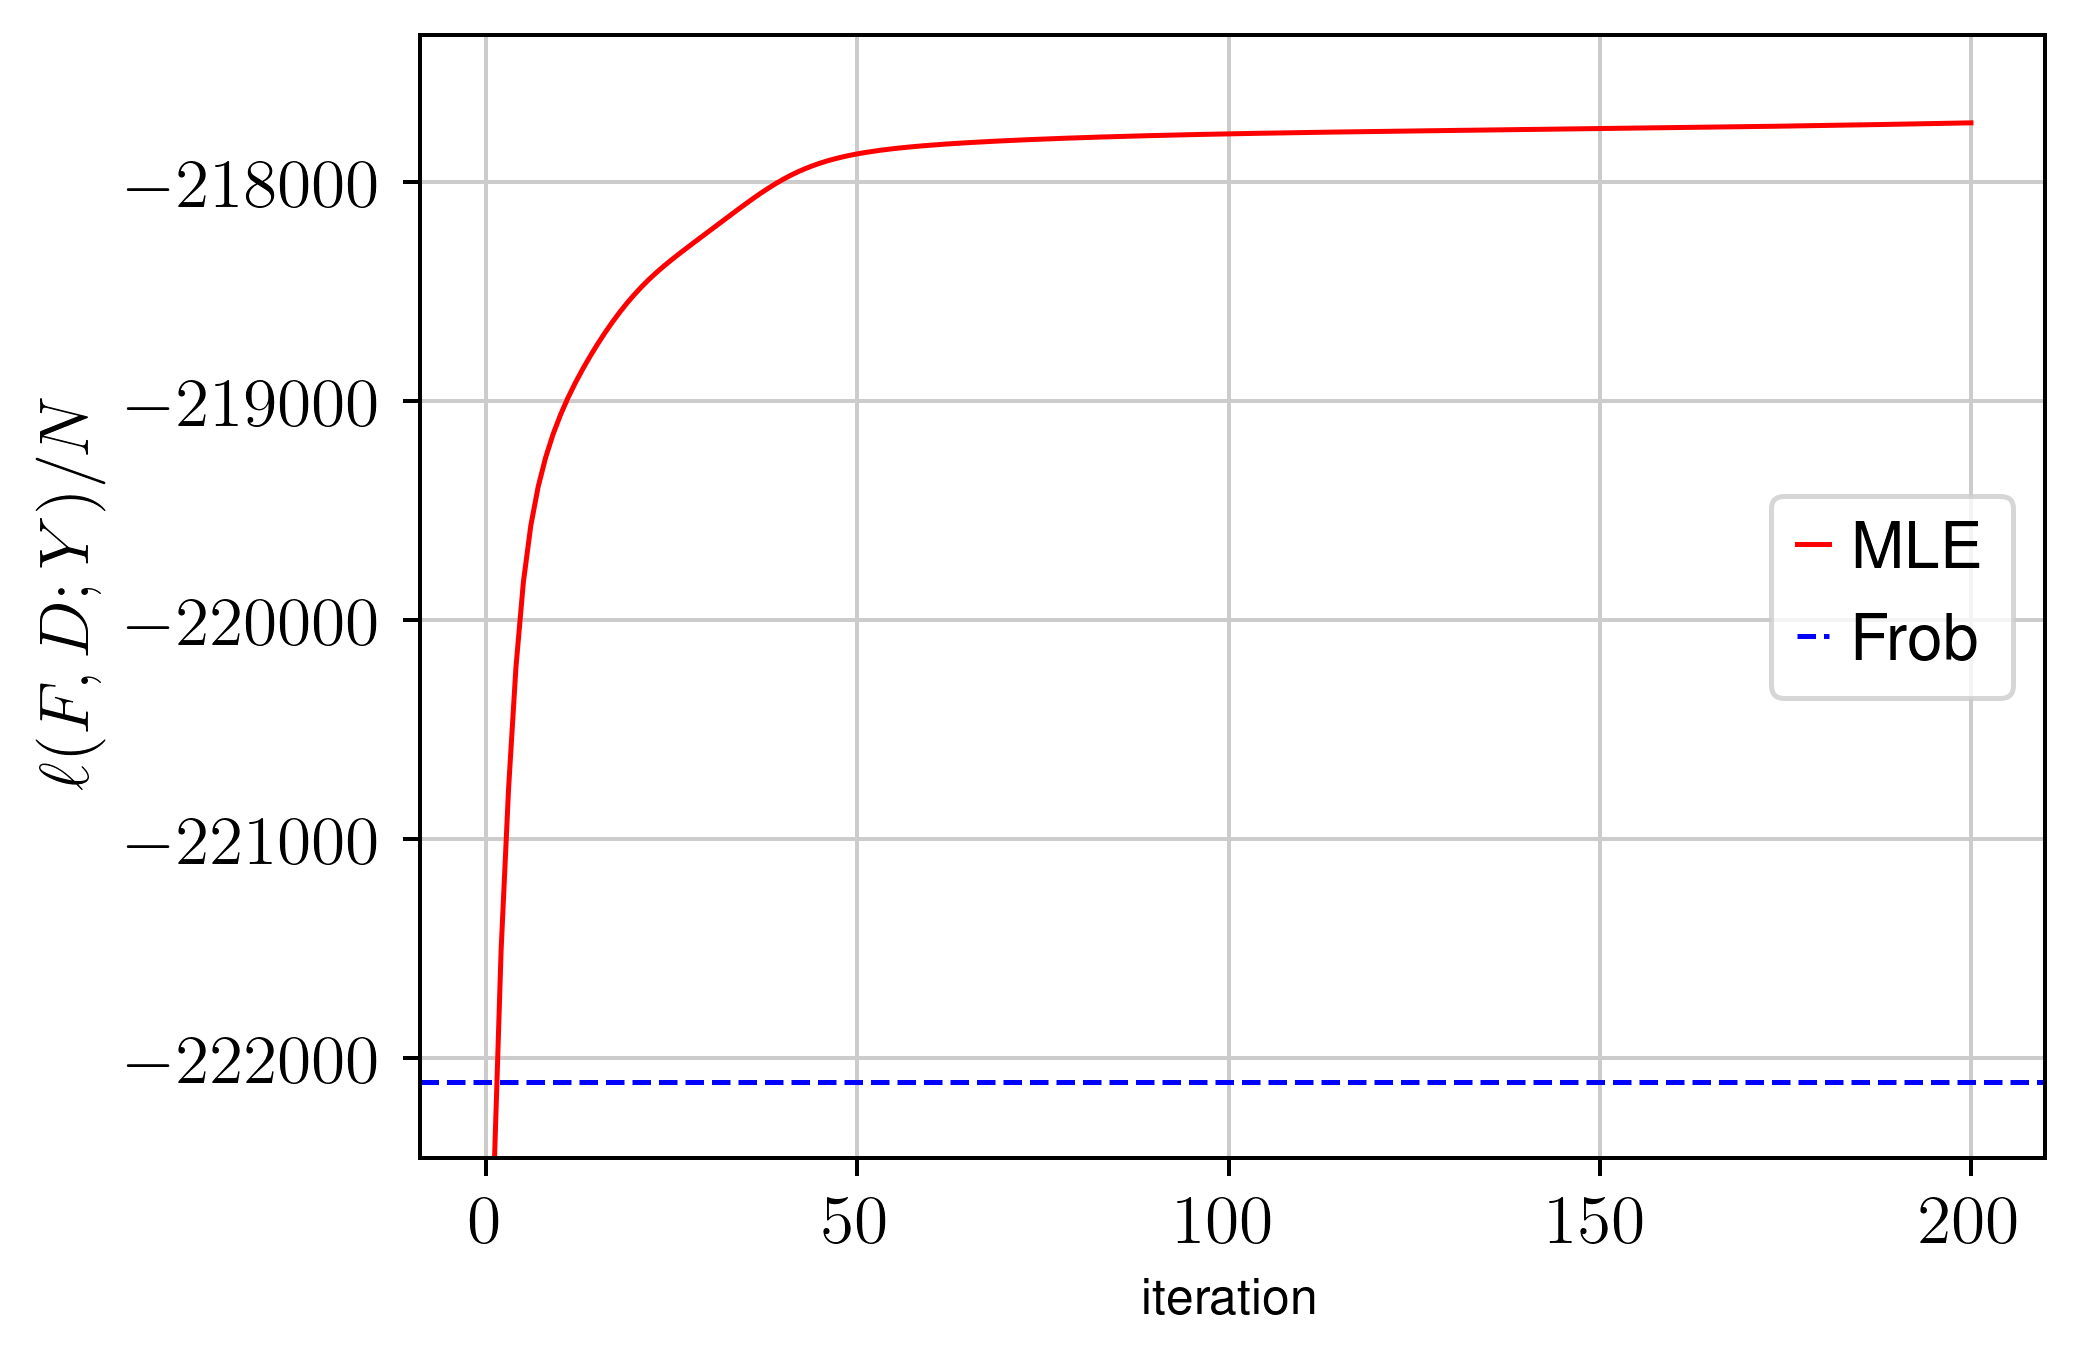

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4), dpi=180, sharey=True)

ll = np.array(loglikelihoods)
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration', fontsize=10)
axs.axhline(obj_frobs, 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$", ls="--")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
axs.set_ylim([obj_frobs - 350, ll.max() + 400])
axs.grid(True)
axs.legend()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

# Plot features

In [34]:
# tissue color for each cell
tissue_types = list(adata.obs["tissue"].unique())
tissue_groups = tissue_c2g_hpart["rows"]["lk"][1]
tissue_pi = tissue_c2g_hpart["rows"]["pi"]
tissue_pi_inv = mf.inv_permutation(tissue_pi, tissue_pi)[0]
true_tissue_colors = np.repeat(np.arange(len(tissue_types)), np.diff(tissue_groups))[tissue_pi_inv]

### Plot $F^{(1)}$ using UMAP.

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

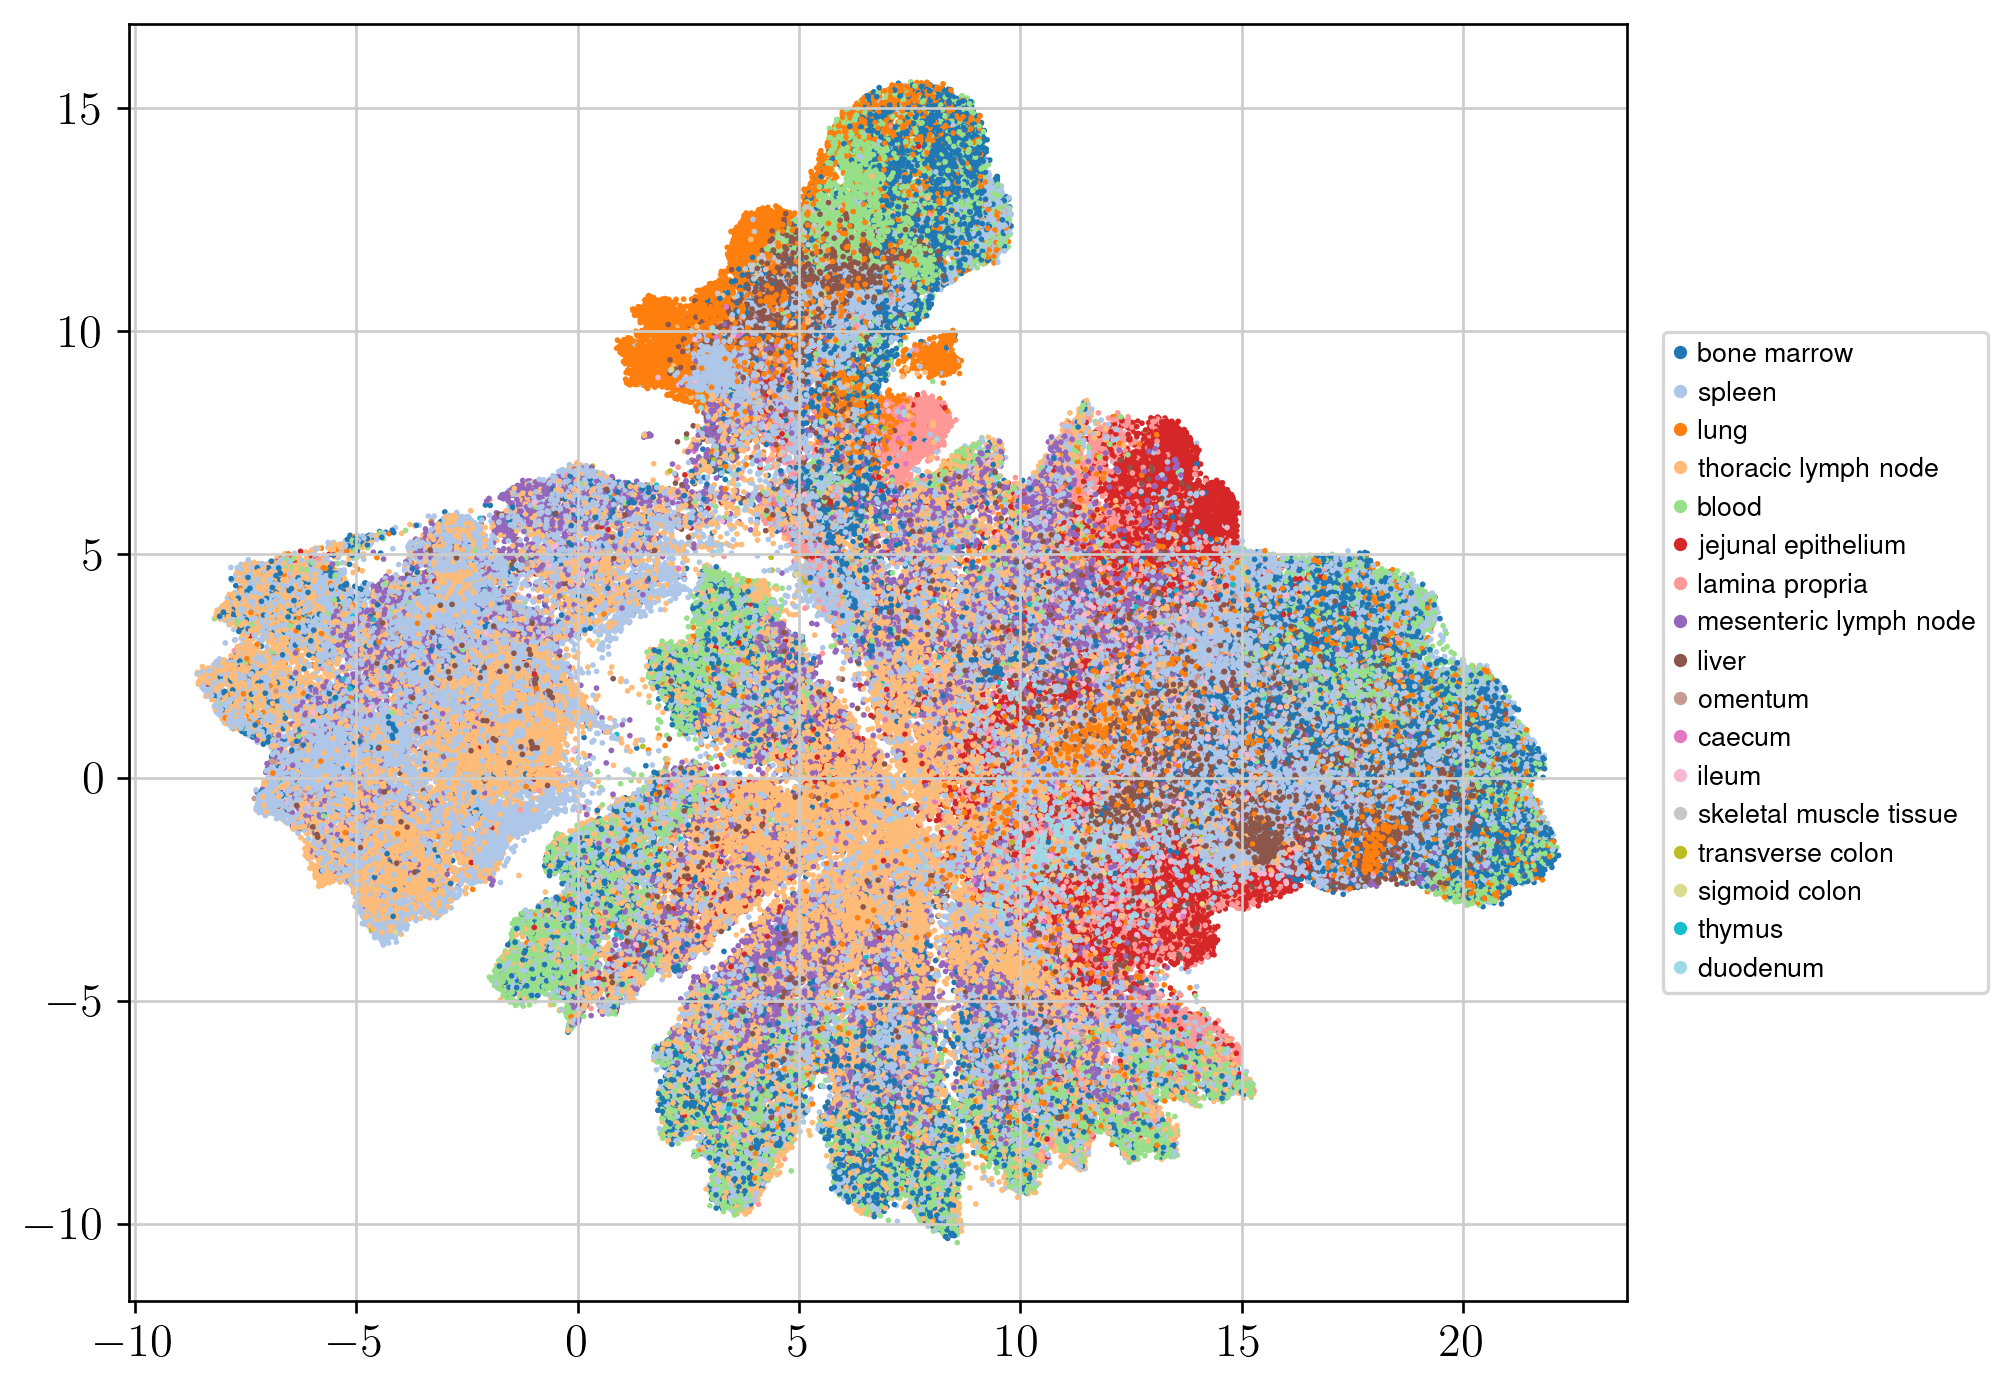

In [35]:
mfm.plot_features(feat=fitted_mfm.F[:, :ranks[0]][fitted_mfm.pi_inv], colors=true_tissue_colors, 
              tissue_types=tissue_types, min_dist=0.5, cmap="tab20")

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

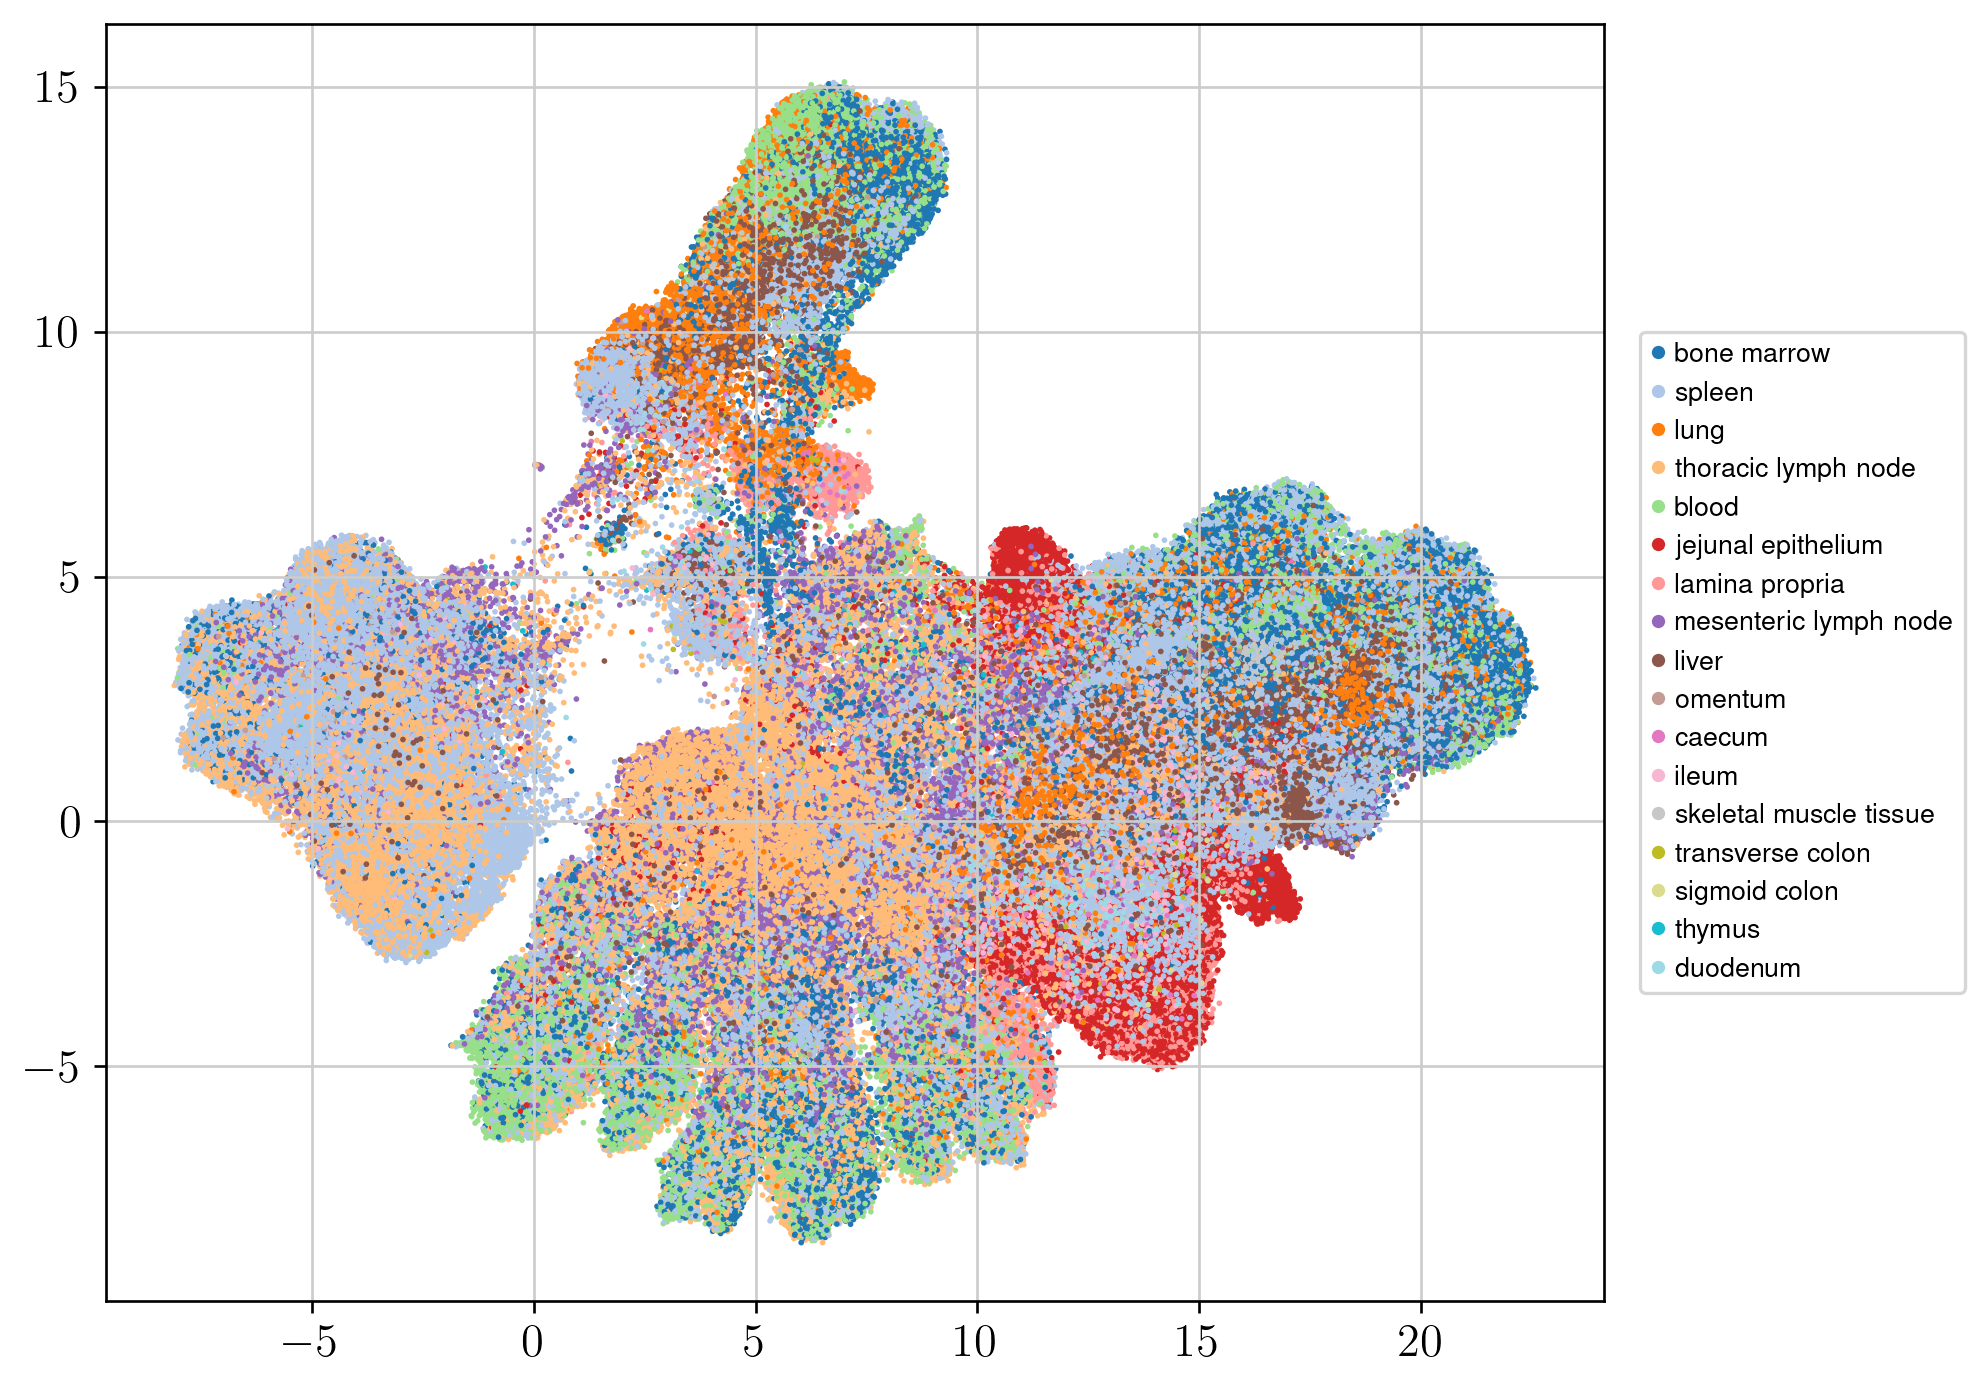

In [36]:
### Plot $F^{(1)}$ using UMAP.
mfm.plot_features(feat=frob_mfm.F[:, :ranks[0]][frob_mfm.pi_inv], colors=true_tissue_colors, 
              tissue_types=tissue_types, min_dist=0.5, cmap="tab20")

num_levels=3, num_sparsities=17
(17, 2) [ 0 16]


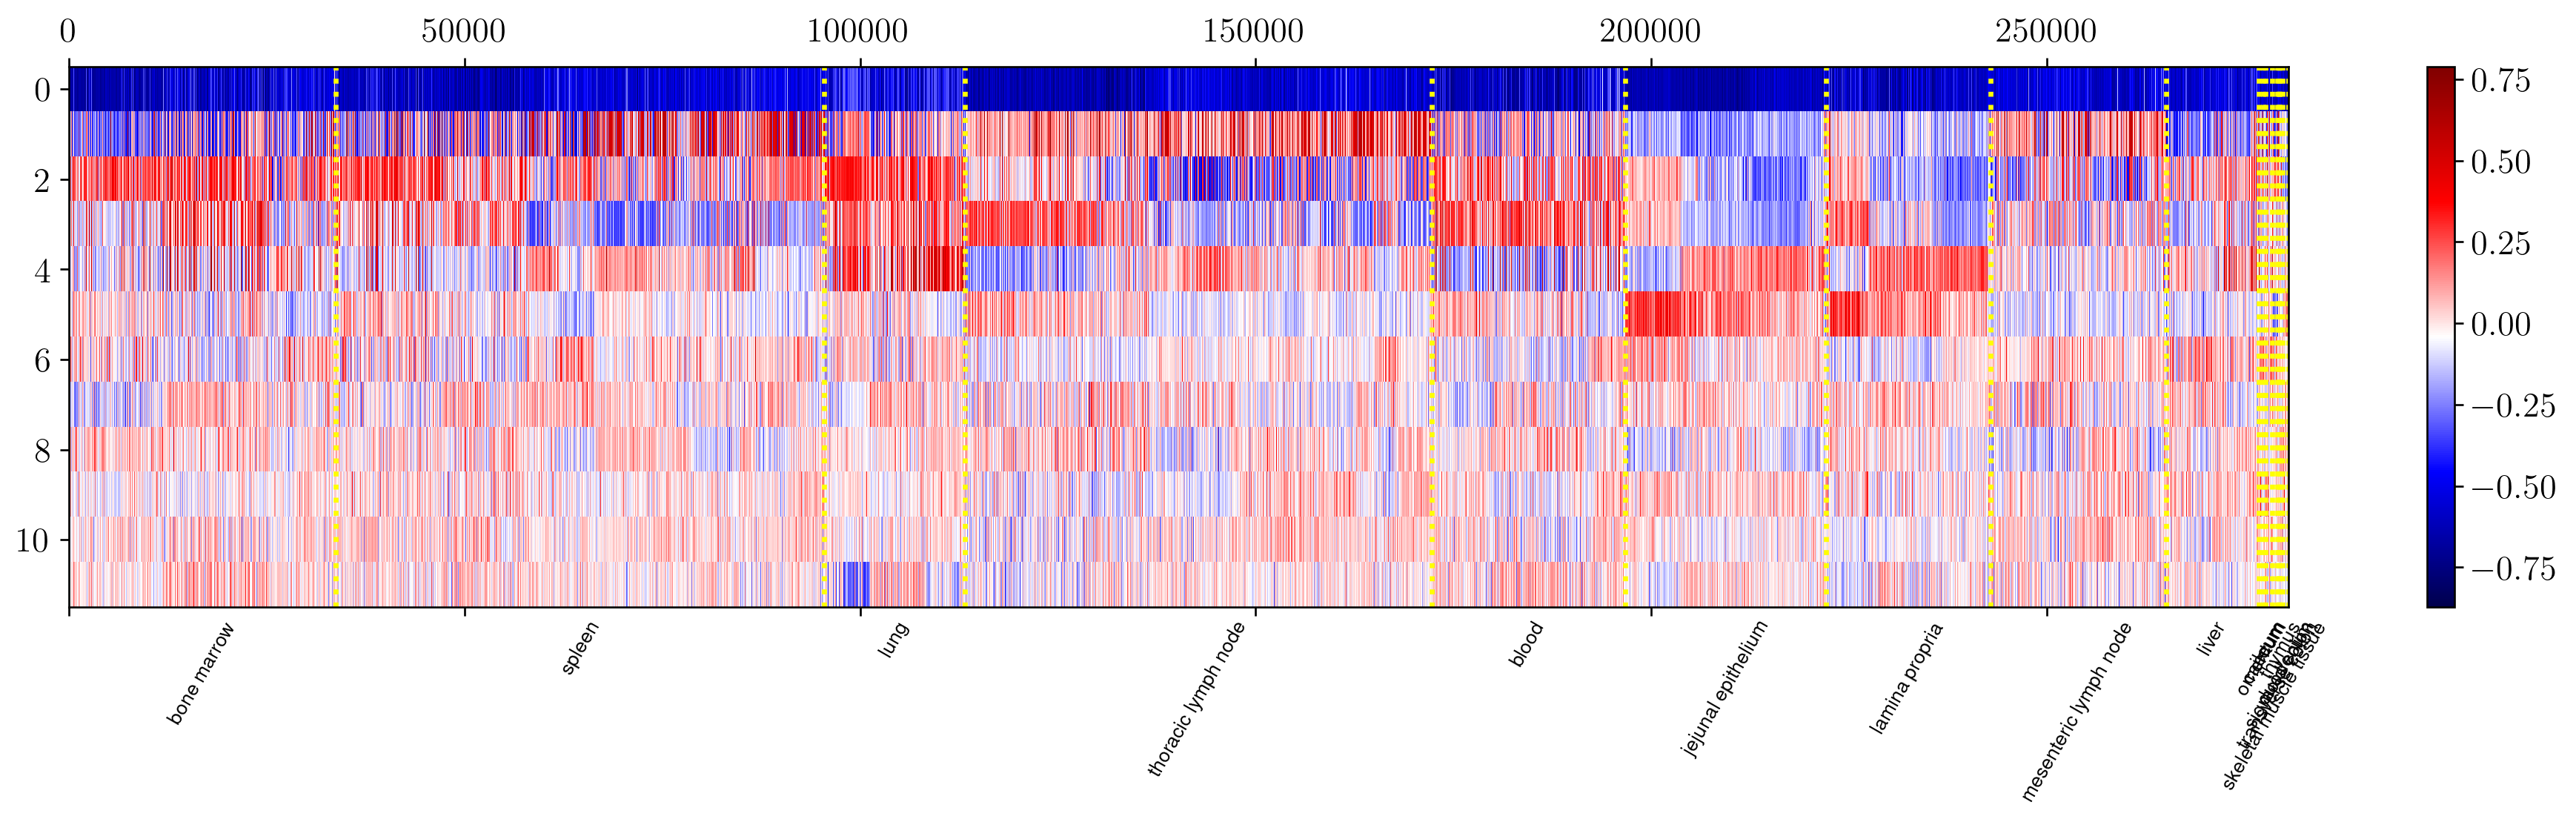

In [37]:
mfm.plot_factors_vs_feat_cellxgene(adata, fitted_mfm, ranks, "tissue", shift=11.75, filename=mtype)

num_levels=3, num_sparsities=43
(43, 2) [ 0 42]


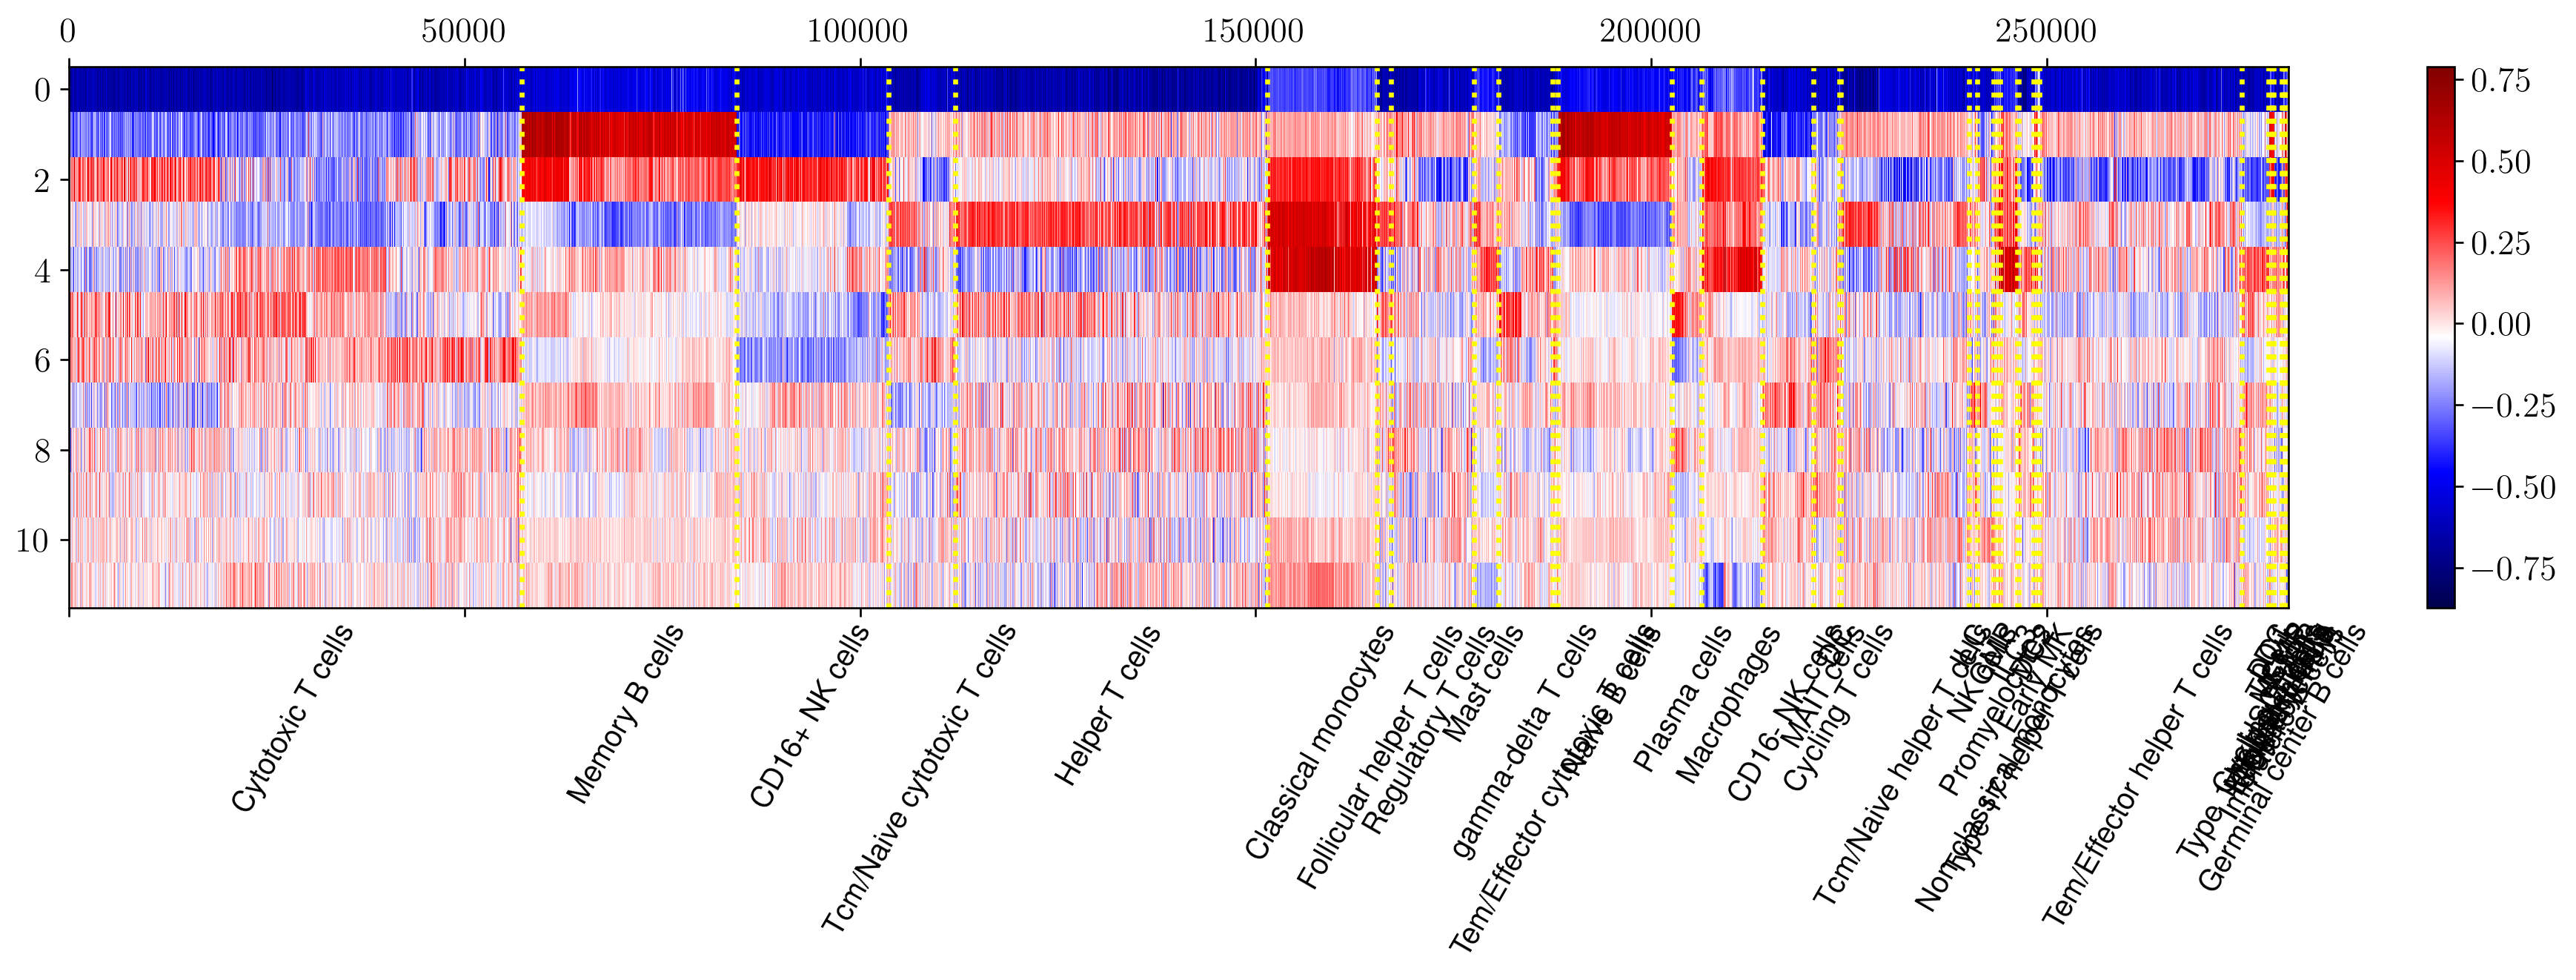

In [ ]:
mfm.plot_factors_vs_feat_cellxgene(adata, fitted_mfm, ranks, "Majority_voting_CellTypist", shift=11.75, filename=mtype, fontsize=11)

num_levels=3, num_sparsities=15
(15, 2) [ 0 14]


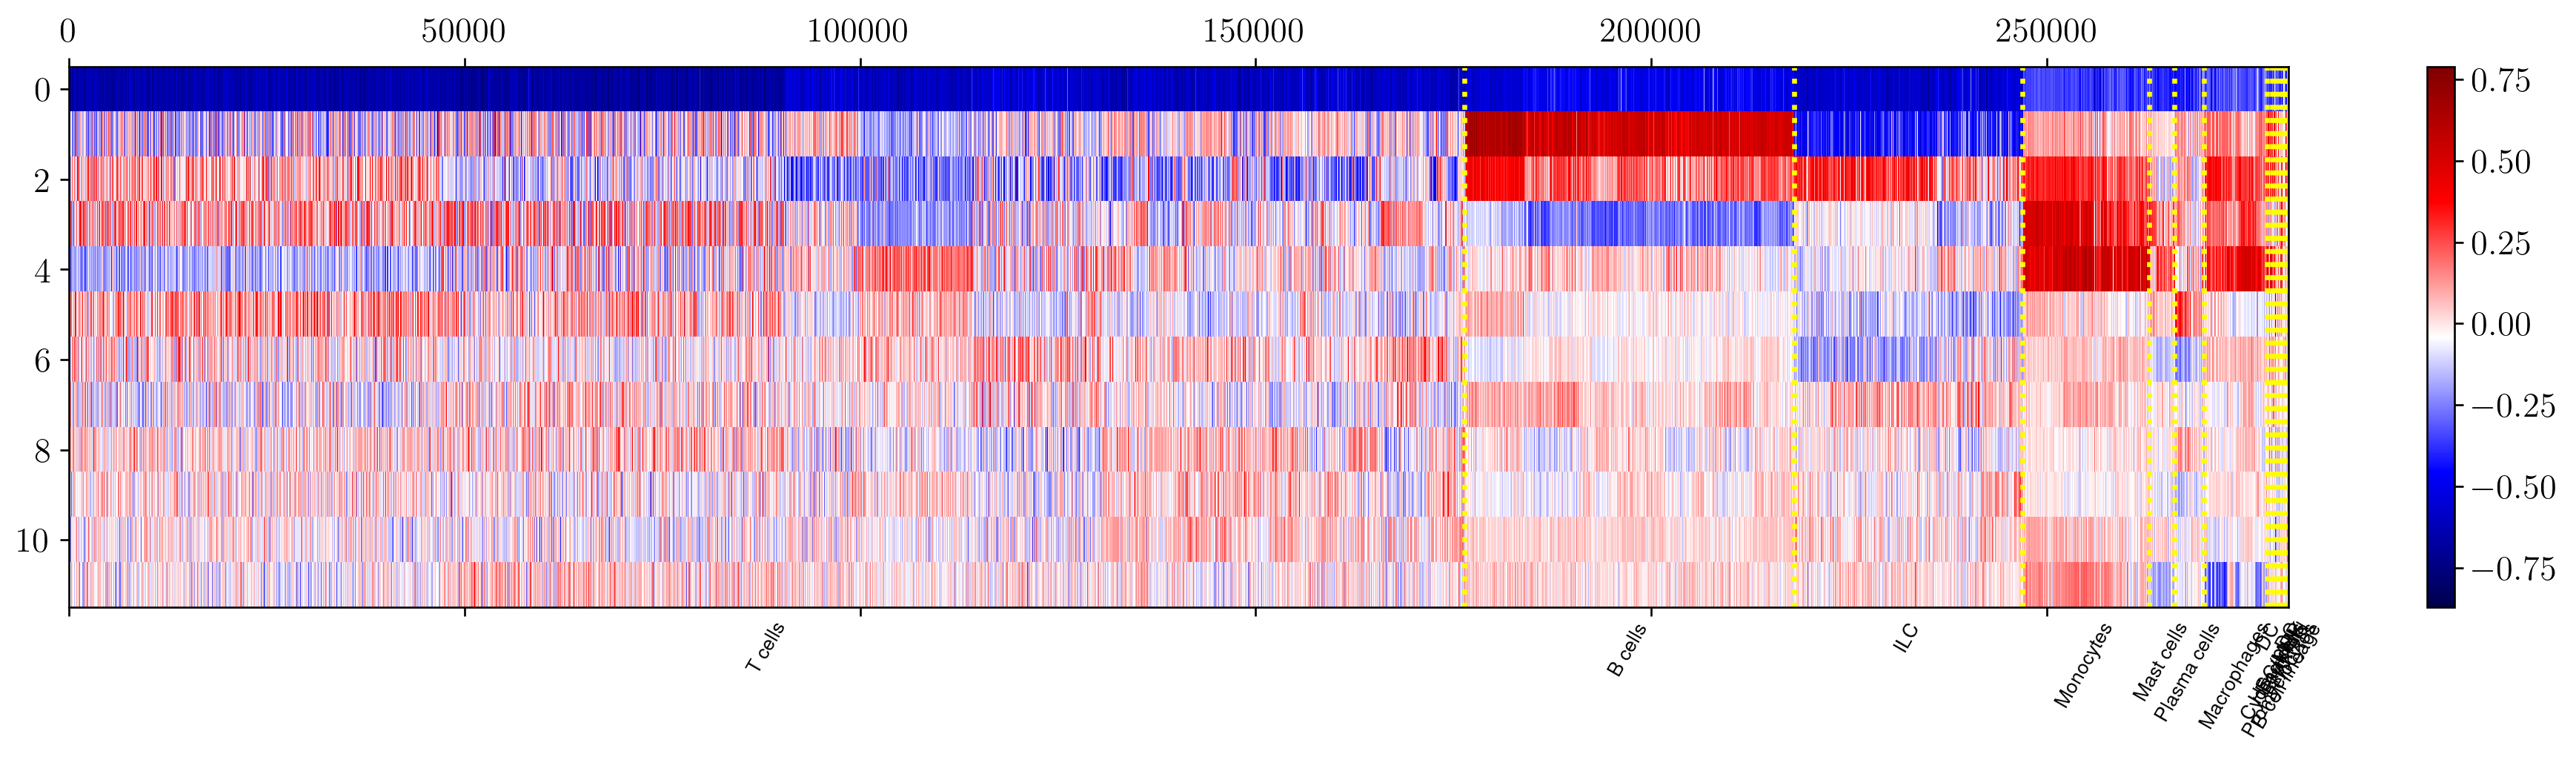

In [39]:
mfm.plot_factors_vs_feat_cellxgene(adata, fitted_mfm, ranks, "Majority_voting_CellTypist_high", shift=11.75, filename=mtype)

In [40]:
adata

AnnData object with n_obs × n_vars = 280535 × 500
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_